# Read in data

In [12]:
HCP=read.table('/dagher/dagher11/filip/HCP_beh//RESTRICTED_uku_7_10_2017_9_43_31.csv',sep=',',header=T)
HCP_u=read.table('/dagher/dagher11/filip/HCP_beh//unrestricted_uku_7_10_2017_9_42_13.csv',sep=',',header=T)
QC=read.table('/dagher/dagher11/filip/HCP_QC/HCP/QC_sbatch/HCP.csv',sep=',',header=T)
QC=QC[, 1:2]
colnames(QC)=c('Subject','QC')

# Merge datasets

In [13]:
All_data=merge(HCP,HCP_u, by='Subject')
All_data=merge(All_data,QC, by='Subject', all.x=T)

# Create initial FSGD

In [14]:
FSGD=data.frame('Variables'='Input', 'Subject'=All_data$Subject, 'Class'='main', 'BMI'=All_data$BMI, 
                'Sex'=All_data$Gender, 'Age'=All_data$Age_in_Yrs, 'QC'=All_data$QC, 'FID'=All_data$Family_ID,
                'Zyg'=All_data$ZygositySR, 'Ethnicity'=All_data$Ethnicity, 'Edu'=All_data$SSAGA_Educ,
                'Income'=All_data$SSAGA_Income, 'Hypothyroid'=All_data$Hypothyroidism, 
                'Hyperthyroid'=All_data$Hyperthyroidism, 'Endocrine'=All_data$OtherEndocrn_Prob)

FSGD[is.na(FSGD)] <- 0 # This is fine because I exclude participants who have 0 in QC and 
                        # leave participants who have 1 in diseases


# Exclude participants who did not pass CT QC

In [17]:
FSGD=FSGD[FSGD$QC==1,]
FSGD$QC=NULL

## Exclude one of each twin pair

In [18]:
FSGD_nt=FSGD[FSGD$Zyg=='NotTwin',]
FSGD_t=FSGD[(FSGD$Zyg=='MZ' | FSGD$Zyg=='NotMZ'),]
FSGD_t=FSGD_t[!duplicated(FSGD_t$FID),]
FSGD=rbind(FSGD_nt,FSGD_t)

# Exclude people with endocrine issues

In [19]:
FSGD=FSGD[FSGD$Hypothyroid==0,]
FSGD=FSGD[FSGD$Hyperthyroid==0,]
FSGD=FSGD[FSGD$Endocrine==0,]

# Remove unnecessary columns

In [20]:
FSGD$FID=NULL
FSGD$Zyg=NULL
FSGD$Hypothyroid=NULL
FSGD$Hyperthyroid=NULL
FSGD$Endocrine=NULL
FSGD$Ethnicity=NULL
#FSGD$Sex=as.numeric(FSGD$Sex)

In [21]:
length(FSGD$Age)

[1] 814

In [9]:
library(psych)

In [23]:
table(FSGD$Sex)


  F   M 
421 393 

In [10]:
describe(FSGD$Age)
describe(FSGD$BMI)
table(FSGD$Sex)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X1,1,814,28.7457,3.741717,29,28.77607,4.4478,22,37,15,-0.04502654,-0.9682246,0.1311471


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X1,1,814,26.59362,5.279214,25.525,26.05305,4.751733,16.65,47.76,31.11,0.9445723,0.7396266,0.1850364


< table of extent 0 >

# Save FSGD

In [246]:
write.table(FSGD, '/dagher/dagher11/filip/Obesity_maps/data/analysis_noethn.fsgd', sep='\t', quote=F, row.names=F)

# HCPA

In [1]:
library(purrr)
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [18]:
data_list=list()

files=c('asr01.txt','edinburgh_hand01.txt','fmriresults01.txt','ssaga_cover_demo01.txt','vitals01.txt',
        'ndar_subject01.txt')

for (i in 1:length(files)){
    data = readLines(paste("/dagher/dagher12/filip/HCP_A/Package_1211418/",files[i],sep=''))
    skip_second = data[-2]
    data = read.csv(textConnection(skip_second), header = TRUE, stringsAsFactors = FALSE, sep='\t')
    drops <- c("dataset_id", "interview_date",'collection_id', 'dataset_id','dayscons',
               'collection_title','comqother','comments_misc','nih_pin','interview_language','wcst_ni',
              'version_form','visit','dode','respondent','nih_tlbx_fctsc','asr01_id')
    data = data[ , !(names(data) %in% drops)]    
    data_list[[i]]=data
}

In [19]:
dataset = data_list %>% reduce(full_join, by=c('subjectkey','sex','interview_age','src_subject_id'))

### Exclude HCA9481794 who failed FS QC

In [4]:
dataset<-dataset[!(dataset$src_subject_id=="HCA9481794"),]

## Calculate and extract data pertinent to further analysis

In [21]:
dataset$BMI=((dataset$weight_std/(dataset$vtl007^2)))*703
dataset$age_yrs=dataset$interview_age/12
dataset$subject_MRI=paste(dataset$src_subject_id,'V1','MR',sep='_')

In [22]:
dataset=dataset[dataset$age_yrs<50,]

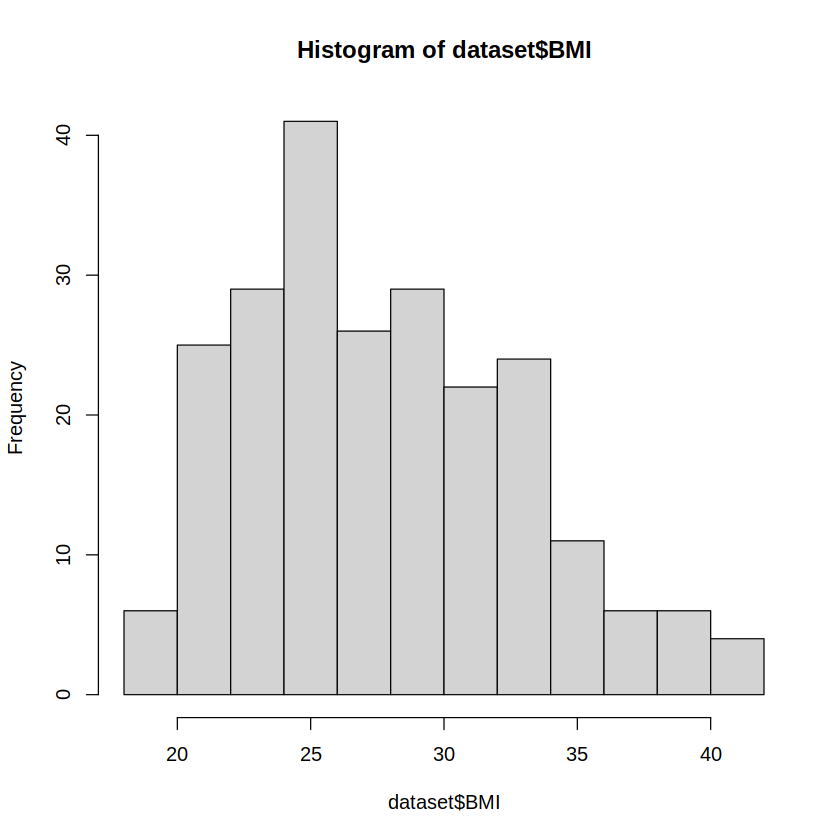

In [23]:
hist(dataset$BMI)

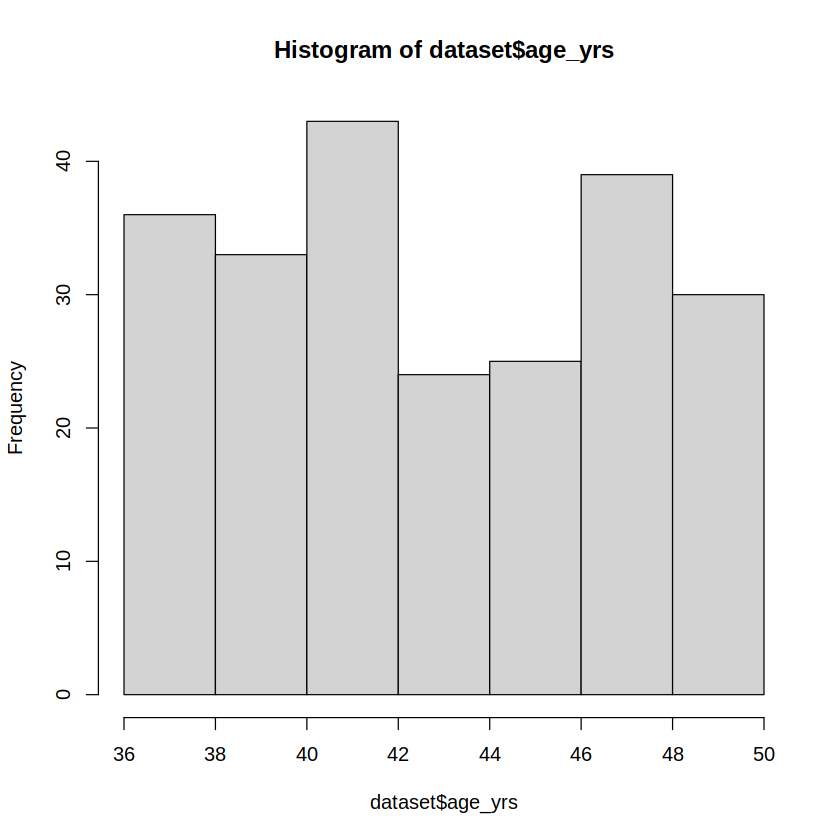

In [19]:
hist(dataset$age_yrs)

In [24]:
table(dataset$sex)
as.numeric(as.factor(dataset$bkgrnd_education))


  F   M 
131  99 

[1]  7  7  6 NA  6  9  6  4  7  7  7  6  9  9 10 NA  9 10  7  9  7  9 NA  7  7
 [26]  5  5  8  9  7  7 10  9  9  9  7  4  9  9  9  7  9  9  9  5  5  5  9  9  7
 [51]  5  7  9  9  5  9  4  7  9  7  9  9  5  9  1  9  9  7  7  9  7  9  7  7  7
 [76]  6  9  5  7  9  7  9  7  9  7 10  7  5  9  9  7 10  7  4  7  4  7  5  8  9
[101]  5  7  7  4  9  9  7  9  4  9  2  7  9  4  9  7  9  9  7 10  7 10  9  9  7
[126]  6  5 10  9  7  9  7  7  7  5  9  7  9  7  4  7  5  9  6 10  9  7  9  9  7
[151]  9  3  9 NA  7  4  4  9  1  9  5  5  9  7  7  9  7  5  5  9  4  7  6  9  5
[176]  9  7  5  7  7  5  7  9  9  7  2  9  7  9  6  9  7  9  9  9  7  5  9  9  7
[201]  9  5  6  7  5  5  5  7  9 10  9  7  7  5  7  9  5  5 10  7  5  7  4  9  5
[226]  4  9  4  9  7

In [25]:
min(as.numeric(dataset$annual_fam_inc),na.rm=T)

[1] 0

In [28]:
FSGD=data.frame('Variables'='Input', 'Subject'=dataset$subject_MRI, 'Class'='main', 'BMI'=dataset$BMI, 
                'Sex'=as.numeric(as.factor(dataset$sex)), 'Age'=dataset$age_yrs,
                'Income'=as.numeric((dataset$annual_fam_inc)), 
                'Edu'=as.numeric(as.factor(dataset$bkgrnd_education)), 'Site'=dataset$site)




In [29]:
write.table(FSGD, '/dagher/dagher11/filip/Obesity_maps/data_old/analysis_HCPA.fsgd', sep='\t', 
            quote=F, row.names=F)

In [30]:
unique(FSGD$Site)

[1] "UCLA"  "MGH"   "WashU" "UMinn"

In [31]:
table(dataset$sex)


  F   M 
131  99 